# Shortest paths

Let's illustrate shortest path routing on the example of Manhattan major street map (downloaded from openstreetmap.org). First let's upload the data, create and visualize the network.

In [1]:
#add necessary libraries
import networkx as nx #library supporting networks
import matplotlib.pyplot as plt #plotting
import pandas as pd
import numpy as np
import scipy.stats as stat
#make sure plots are embedded into the notebook
%pylab inline 
import statsmodels.formula.api as smf

Populating the interactive namespace from numpy and matplotlib


In [2]:
#upload NYC intersections
NYCintersections = pd.read_csv( 'https://serv.cusp.nyu.edu/files/ADS-2015/NetworkAnalysis/lab2/ManhattanStreetMap_nodes.csv' , index_col=0, header=-1 )
NYCintersections.columns=['Y','X','m']
NYCintersections.head()

,Y,X,m
0,,,
30807307,40.792136,-73.962155,0
30807308,40.791991,-73.962188,0
30807309,40.791755,-73.962361,0
30807310,40.791482,-73.962549,0
30807311,40.791263,-73.962740,0


In [3]:
#read the network edges - street connections between adjacent nodes
#(extracted from the openstreetmap ways with respect to one-way flag)
NYCstreets = pd.read_csv( 'https://serv.cusp.nyu.edu/files/ADS-2015/NetworkAnalysis/lab2/StreetMap_edges.csv' , index_col=None, header=-1 )
NYCstreets.columns=['A','B']
NYCstreets.head()

,A,B
0,33583379,33583380
1,33583380,33583379
2,33583380,33583381
3,33583381,33583380
4,33583381,33583382


In [4]:
#number of street intersections on Lower Manhattan
InManhattan={}
for c in NYCintersections.index:
    InManhattan[c]=NYCintersections.m[c]

In [5]:
#create a dictionary of intersection locations and Manhattan flags
IntPos={}
for c in NYCintersections.index:
    IntPos[c]=(NYCintersections.X[c],NYCintersections.Y[c])

In [6]:
#creare a directed graph representing street network
NYCStreets=nx.DiGraph()
for i in NYCstreets.index:
    #adding only streets inside Manhattan
    if InManhattan[NYCstreets.A[i]]&InManhattan[NYCstreets.B[i]]:
       NYCStreets.add_edge(NYCstreets.A[i],NYCstreets.B[i])

In [7]:
#take the largest strongly connected component for having a connected network of major streets (it somehow happened during the parsing that minor roads got disconneted from the major ones as being absent among the ways)
MLC=sorted(nx.strongly_connected_components(NYCStreets), key=len, reverse=True)
NYCStreetsC=NYCStreets.subgraph(MLC[0])

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


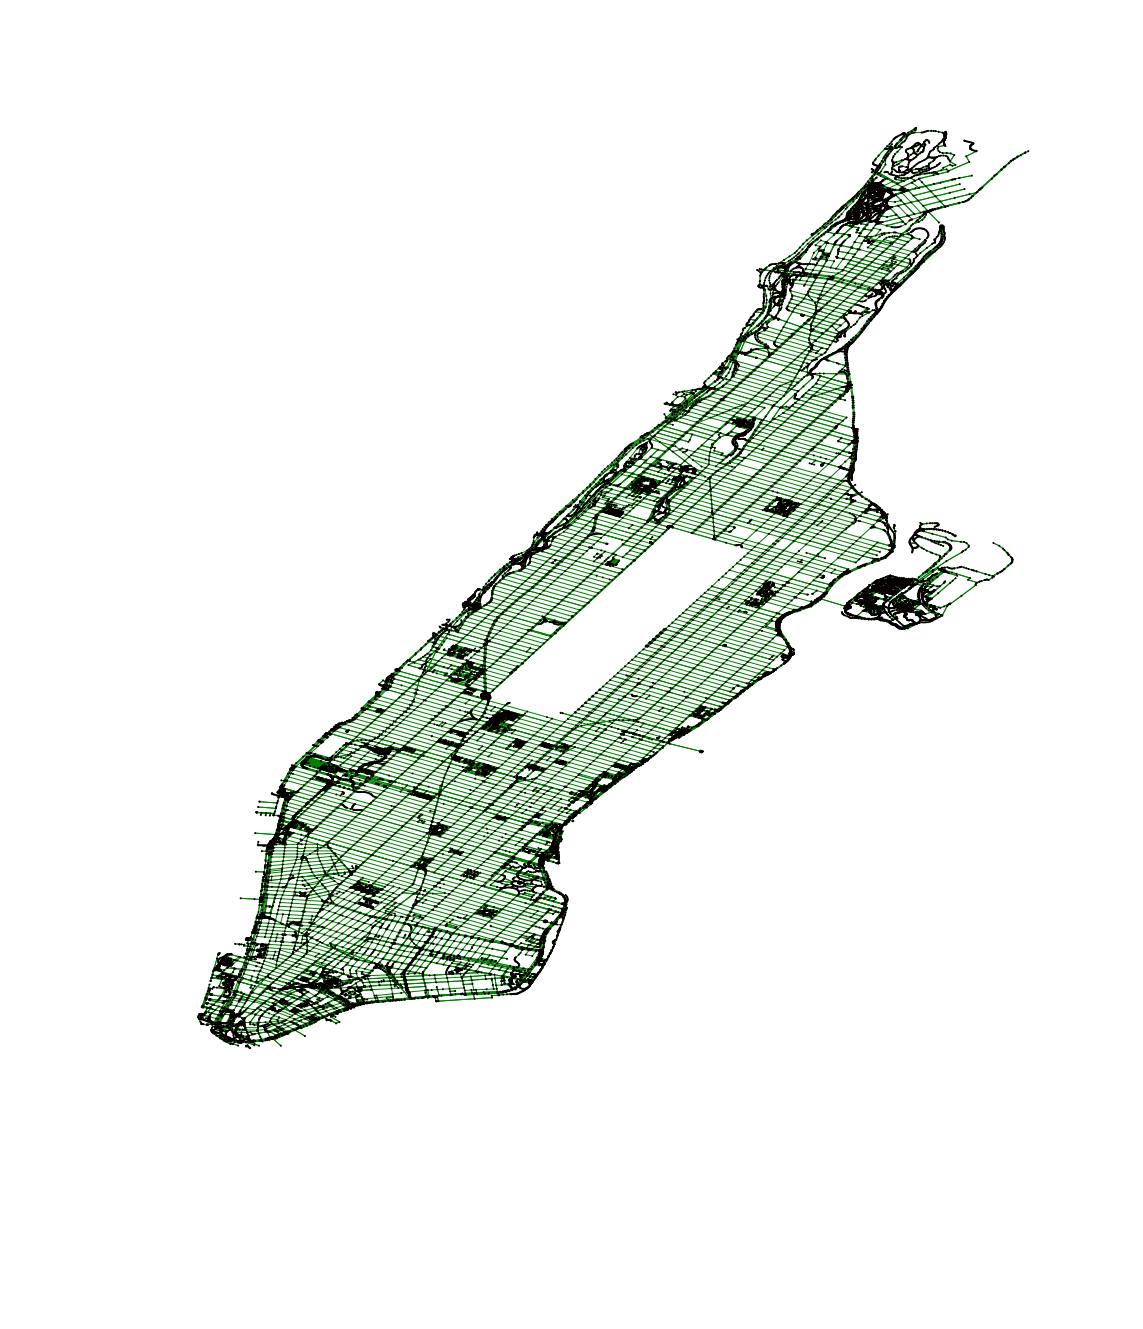

In [8]:
#visualize the street newtork
plt.figure(figsize = (15,18))
nx.draw(NYCStreetsC,pos=IntPos,with_labels=False,arrows=False,node_size=1,width=1,edge_color='green')

Now once the network is set up, add geographical distances to the edges

In [9]:
#auxiliary function: geodesic distance on the Earth surface between two lat-long points
from math import sin, cos, sqrt, atan2, radians
def geodist(lon1,lat1,lon2,lat2):
    lat1 = radians(lat1)
    lon1 = radians(lon1)  
    lat2 = radians(lat2)
    lon2 = radians(lon2)
    R = 6373.0
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

In [10]:
#add length attribute to the edges
nx.set_edge_attributes(NYCStreetsC, 'dist', 0)

In [11]:
#compute and assing lengths the all the edges
for e in NYCStreetsC.edges():
   NYCStreetsC[e[0]][e[1]]['dist']=geodist(IntPos[e[0]][0],IntPos[e[0]][1],IntPos[e[1]][0],IntPos[e[1]][1])

Now the network is ready for the routing experiments. Define several major points of interest: World Trade Center (-74.0125,40.7117), Empire State Building (-73.9857,40.7484) and Metropolitan Museum of Art (-73.9637, 40.7789).

In [14]:
#auxiliary function for locating intersections of interest: get the closest street intersection to a given point
def closest(lon,lat):
    c=0
    d=Inf
    for n in NYCStreetsC.nodes():
        d1=geodist(IntPos[n][0],IntPos[n][1],lon,lat)
        if d1<d:
            c=n
            d=d1
    return c        

In [15]:
#find node closest to world trade center, Empire State Building and Metropolitan Museum of Art
node_wtc=closest(-74.0125,40.7117)
node_emp=closest(-73.9857,40.7484)
node_mma=closest(-73.9637,40.7789)
print('WTC:{0}'.format(node_wtc))
print('Empire St. Bld.:{0}'.format(node_emp))
print('Metropolitan Museum:{0}'.format(node_mma))

WTC:2790429007
Empire St. Bld.:42446701
Metropolitan Museum:3392519842


In [17]:
#compute shortest paths, first without distances, just number of edges
path_wtc_emp=nx.shortest_path(NYCStreetsC,node_wtc,node_emp)

In [19]:
path_wtc_mma=nx.shortest_path(NYCStreetsC,node_wtc,node_mma)

In [20]:
len(path_wtc_mma)

89

In [41]:
#auxiliary function - visualize path on the map
def visualize_path(path):
    plt.figure(figsize = (15,18))
    nx.draw(NYCStreetsC,pos=IntPos,with_labels=False,arrows=False,node_size=1,width=1,edge_color='green')
    x=[IntPos[v][0] for v in path]
    y=[IntPos[v][1] for v in path]
    plt.plot(x,y,'ro-')
    plt.plot([x[0],x[-1]],[y[0],y[-1]],'bs',markersize=10)

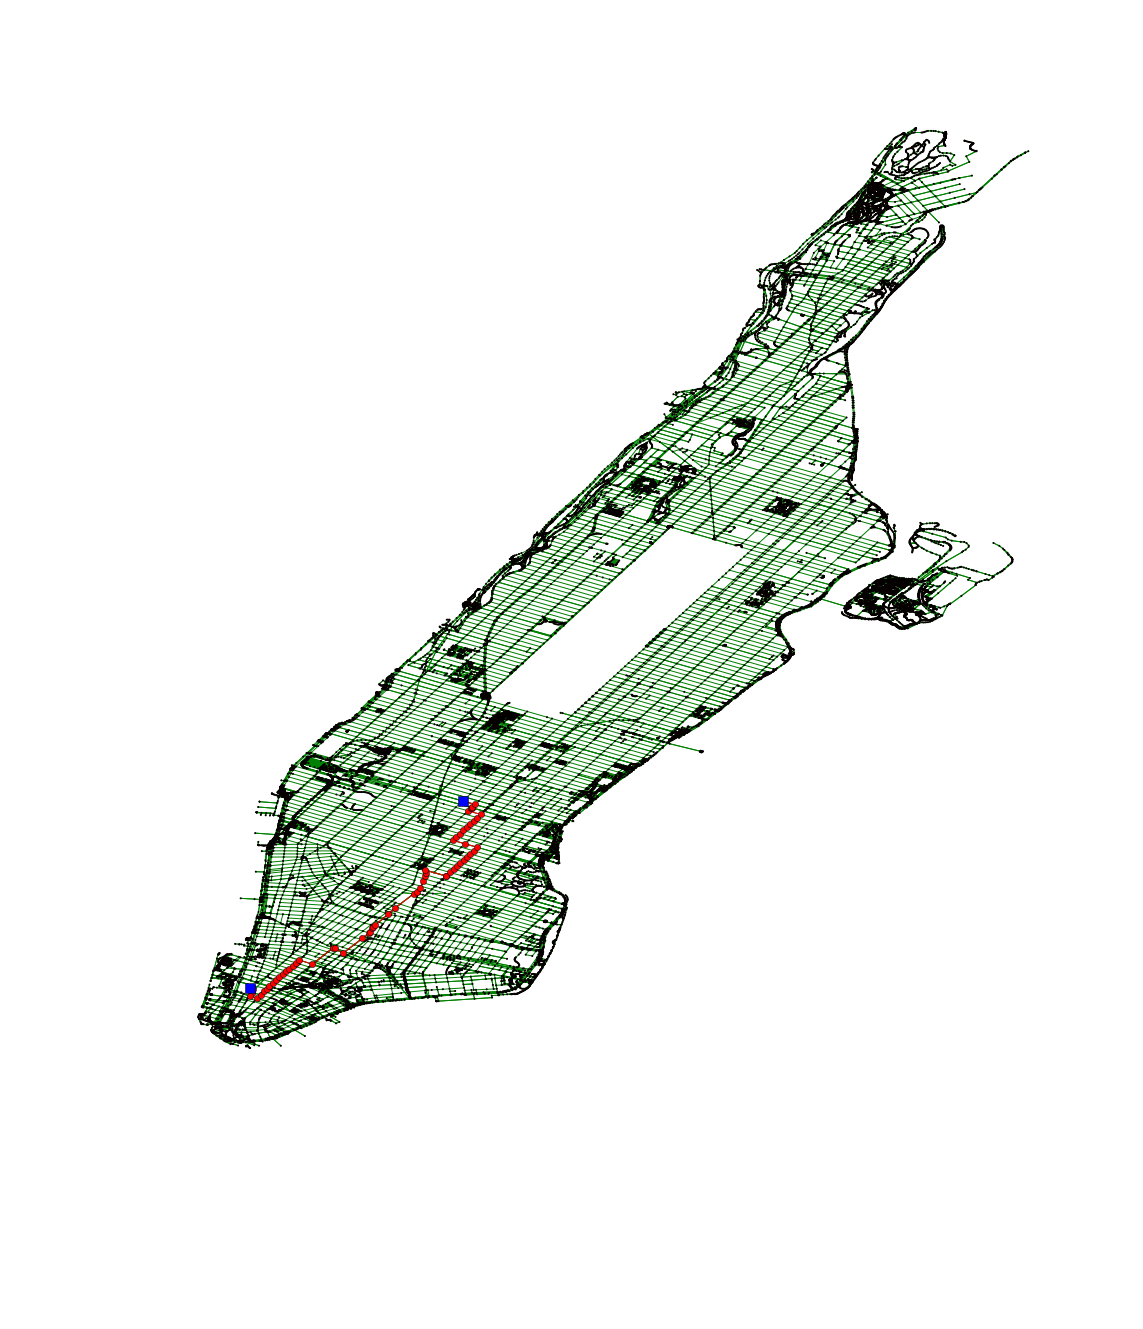

In [43]:
visualize_path(path_wtc_emp)

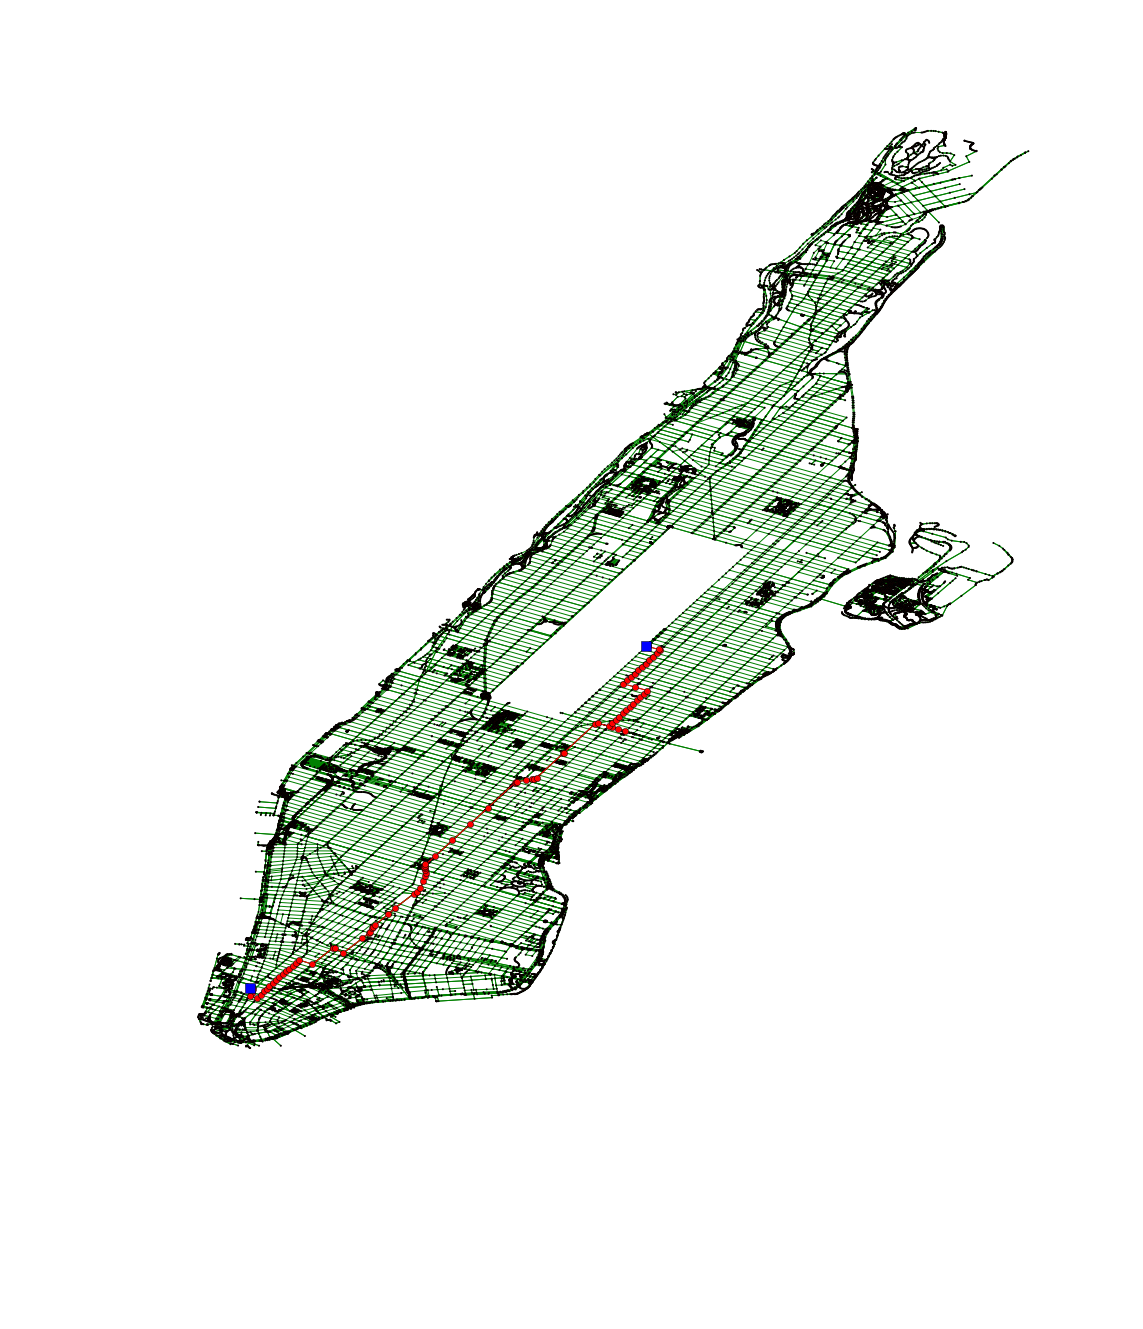

In [42]:
visualize_path(path_wtc_mma)

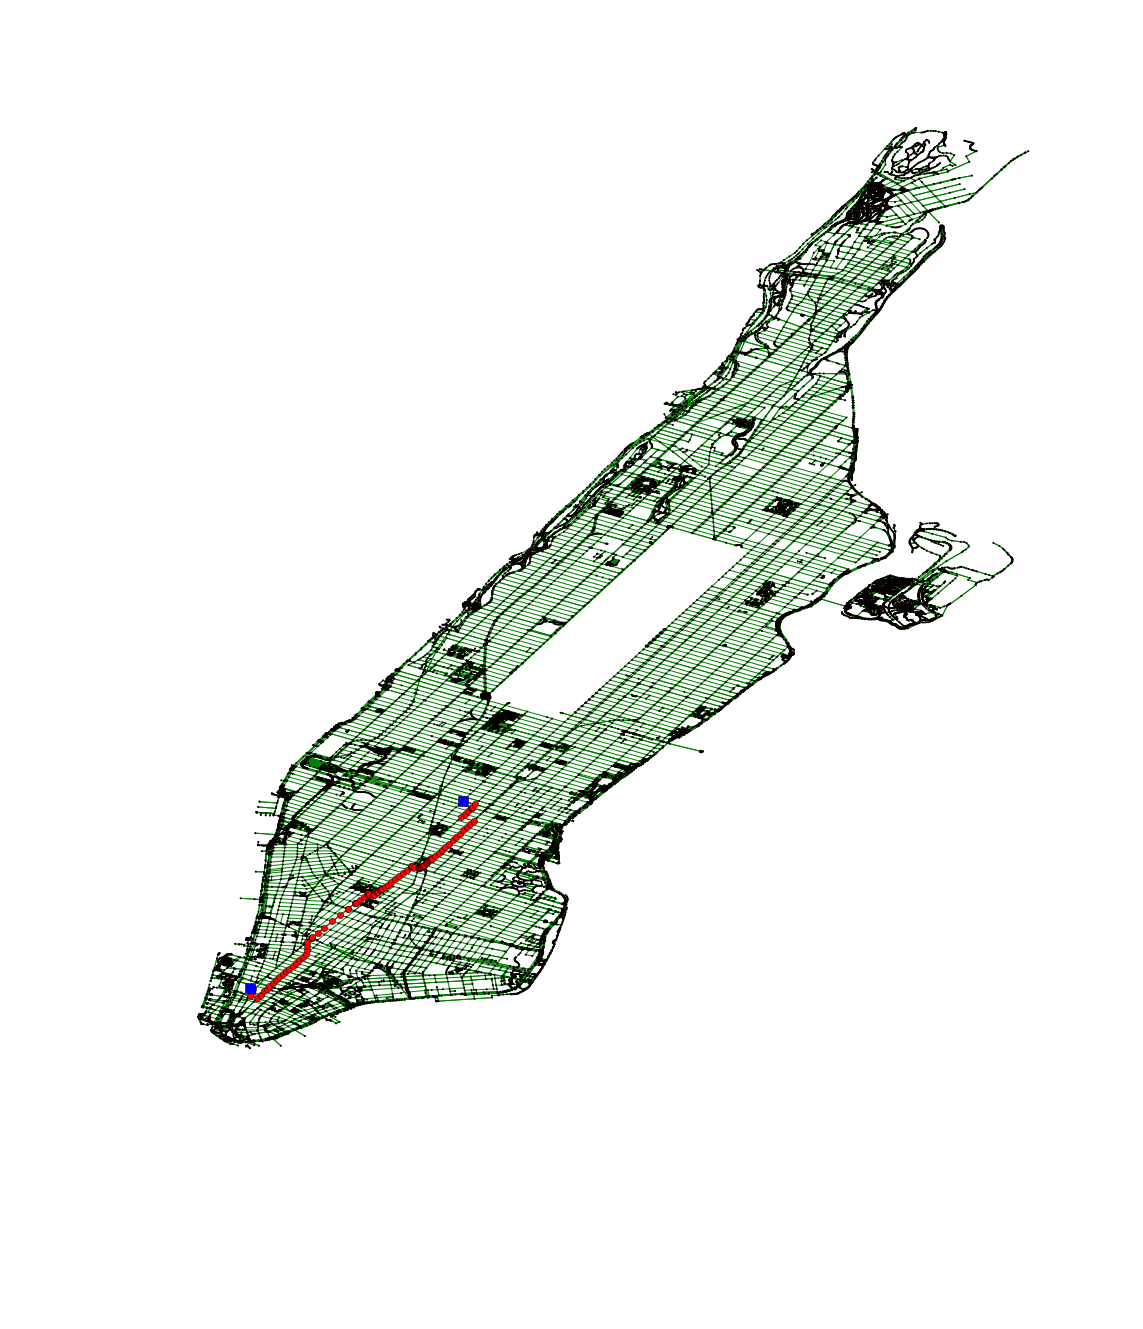

In [44]:
# now take distances into consideration
path_wtc_emp_dist=nx.shortest_path(NYCStreetsC,node_wtc,node_emp,'dist')
visualize_path(path_wtc_emp_dist)

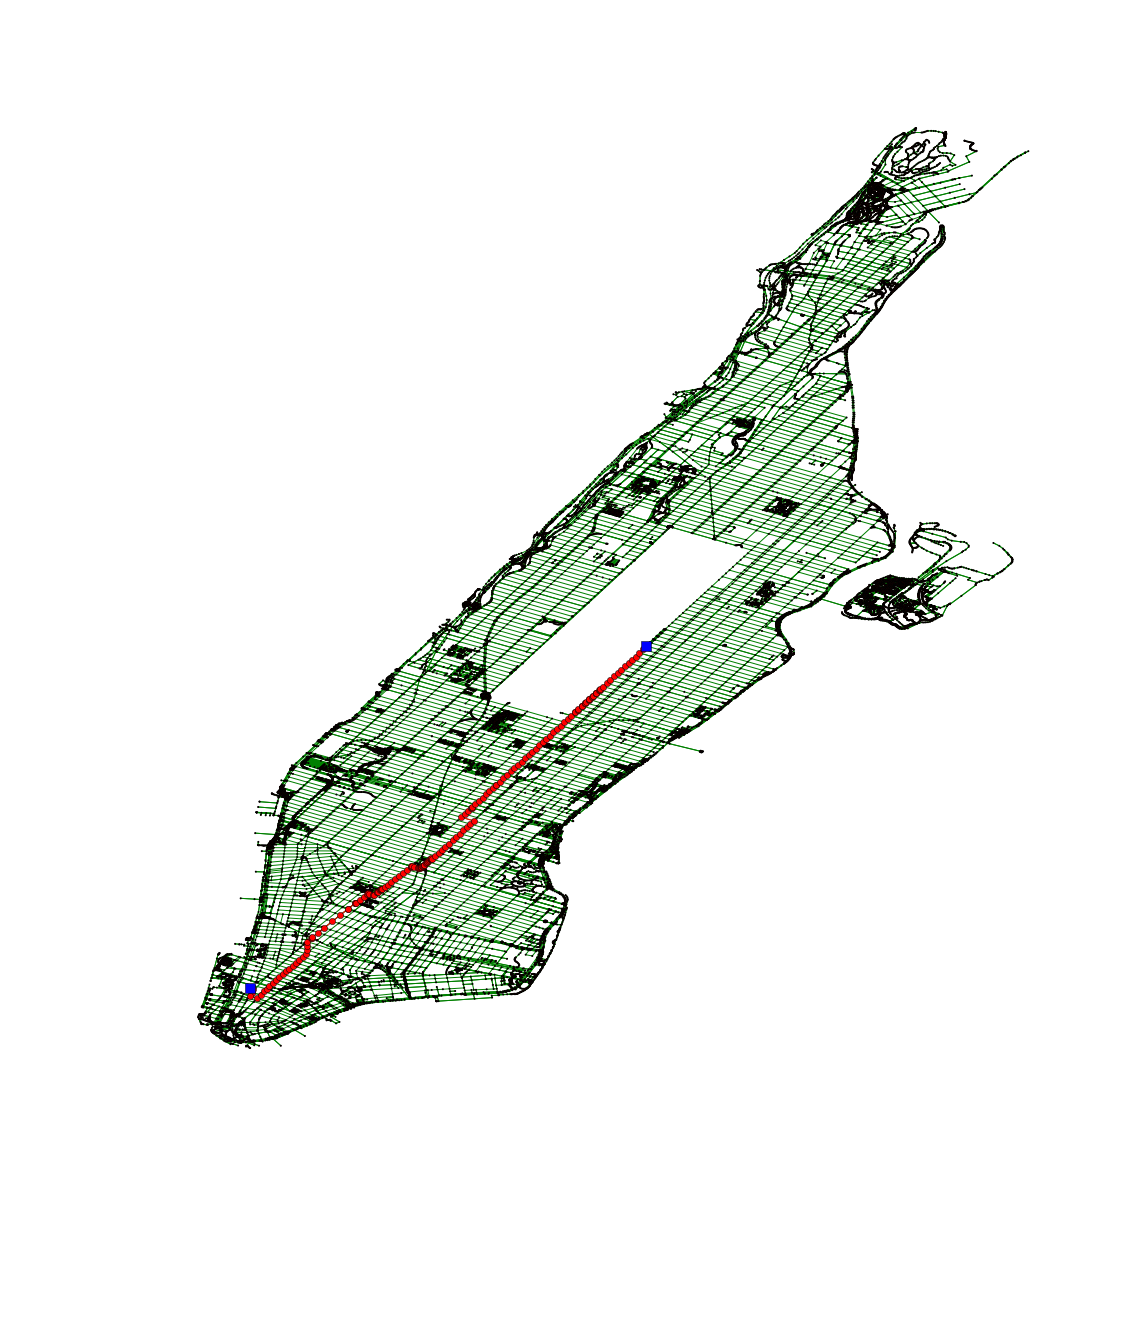

In [45]:
# now take distances into consideration
path_wtc_mma_dist=nx.shortest_path(NYCStreetsC,node_wtc,node_mma,'dist')
visualize_path(path_wtc_mma_dist)

## Problem 1
Find fastest path in terms of time between WTC and Metropolitan Museum, where travel time is defined with respect to average driving spead of 9.35 MPH and average delay of 15 seconds for each intersection passed.

## Problem 2
With respect to the travel time as above find the most distant (timewise) node from World Trade Center and visualize the shortest path. Hint: use nx.shortest_path_length

## Problem 3
With respect to the travel time as above find the most distant node highest pagerank node (a=0.85) within 45 min travel from Metropolitan Museum of Art.

## Problem 4
With respect to the travel time and pagerank centrality measures as above find the best node $a$ around Metropolitan Museum of Art $a_0$ in terms of a tradeoff 
$$
t={\rm centrality}(a)-\lambda {\rm time}(a,a_0)
$$
for different $\lambda=1e-8, 3e-8, 1e-7, 3e-7$.